## Persiapan
### Mengimpor library yang dibutuhkan

In [101]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import requests
import zipfile
from pathlib import Path

import os
import random
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import torchinfo

### Device Agnostic

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Tersedia GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Tersedia MPS Apple Silicon")
else:
    device = torch.device("cpu")
    print("Tersedia CPU")

Tersedia GPU


## Mempersiapkan Data

### Mengunduh Dataset

In [8]:
ROOT_PATH = Path("data")
DATA_PATH = Path("data/pizza_steak_sushi")

if DATA_PATH.is_dir():
    print(f"Folder {DATA_PATH} sudah ada")
else:
    print(f"Folder {DATA_PATH} belum ada. Membuat folder...")
    DATA_PATH.mkdir(parents=True, exist_ok=True)

    # Downlaod data
    with open(ROOT_PATH / "pizza_steak_sushi.zip", "wb") as f:
        print(f"Mendownload data ke {ROOT_PATH / 'pizza_steak_sushi.zip'}")
        response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(response.content)
        print(f"Data berhasil di download ke {ROOT_PATH / 'pizza_steak_sushi.zip'}")

    # Extract data
    with zipfile.ZipFile(ROOT_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(DATA_PATH)
        print(f"Data berhasil di ekstrak ke {DATA_PATH}")

Folder data\pizza_steak_sushi belum ada. Membuat folder...
Mendownload data ke data\pizza_steak_sushi.zip
Data berhasil di download ke data\pizza_steak_sushi.zip
Data berhasil di ekstrak ke data\pizza_steak_sushi


### Menjelajahi Data

In [10]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(dirnames)} folder dan {len(filenames)} file di {dirpath}")

In [11]:
walk_through_dir(DATA_PATH)

Ada 2 folder dan 0 file di data\pizza_steak_sushi
Ada 3 folder dan 0 file di data\pizza_steak_sushi\test
Ada 0 folder dan 25 file di data\pizza_steak_sushi\test\pizza
Ada 0 folder dan 19 file di data\pizza_steak_sushi\test\steak
Ada 0 folder dan 31 file di data\pizza_steak_sushi\test\sushi
Ada 3 folder dan 0 file di data\pizza_steak_sushi\train
Ada 0 folder dan 78 file di data\pizza_steak_sushi\train\pizza
Ada 0 folder dan 75 file di data\pizza_steak_sushi\train\steak
Ada 0 folder dan 72 file di data\pizza_steak_sushi\train\sushi


### Membagi Dataset Training dan Testing

In [12]:
train_dir = DATA_PATH / "train"
test_dir = DATA_PATH / "test"

### Mencoba Memuat Gambar

Ada 300 gambar
Random Image Path: data\pizza_steak_sushi\train\steak\2628106.jpg
Random Image Class: steak
Random Image Size: (512, 512)


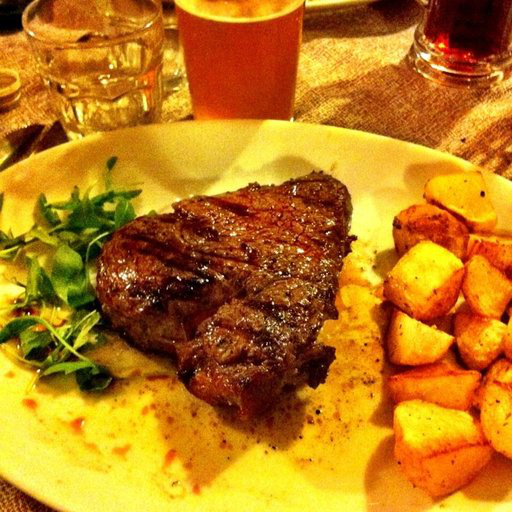

In [32]:
image_path_list = glob(str(DATA_PATH / "*/*/*.jpg"))
print(f"Ada {len(image_path_list)} gambar")

# random image
random.seed(2023)
random_image_path = random.choice(image_path_list)

# memuat kelas dari gambar
random_image_class = random_image_path.split(os.sep)[-2]

# menampilkan gambar
img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Random Image Class: {random_image_class}")
print(f"Random Image Size: {img.size}")
img

## Transformasi Data

### Membuat fungsi untuk transformasi data

In [81]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

### Membuat Fungsi Untuk Plot Gambar yang Ditransformasi

In [82]:
def plot_transformed_images(image_paths, transform, n=3):
    # random.seed(2023)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            plt.figure(figsize=(10, 5))
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Image Size: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Size: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Image Class: {image_path.split(os.sep)[-2]}")

<Figure size 1000x500 with 0 Axes>

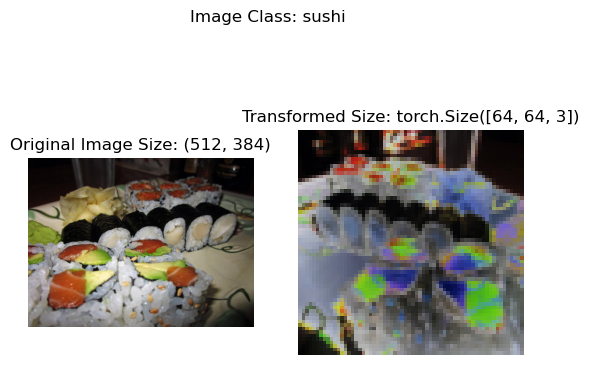

<Figure size 1000x500 with 0 Axes>

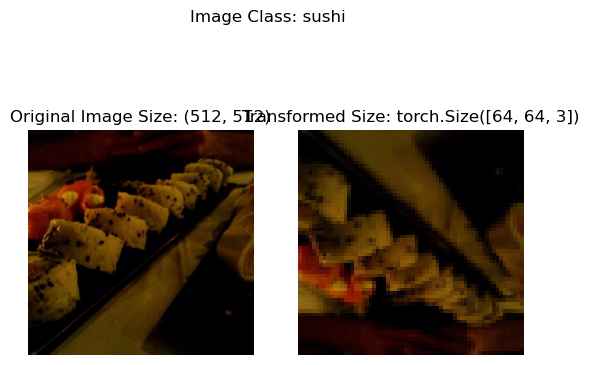

<Figure size 1000x500 with 0 Axes>

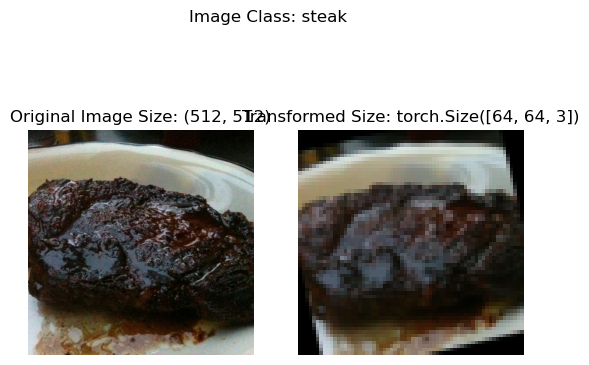

In [83]:
plot_transformed_images(image_path_list, data_transform)

## Memuat Dataset

### Memuat Dataset Train dan Test dengan ImageFolder

In [ ]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None,
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform
)

print(f"Train Data: \n{train_data} \n Test Data: \n{test_data}")

Train Data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           ) 
 Test Data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
print(f"Panjang Train Data: {len(train_data)} \nPanjang Test Data: {len(test_data)}")

Panjang Train Data: 225
Panjang Test Data: 75


### Membuat List Kelas

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
print(f"Class Dictionary: {class_dict}")

Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


## Memuat DataLoader

### Memuat DataLoader Train dan Test

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=2,
    num_workers=8,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=1,
    shuffle=False,
)

### Mencoba DataLoader

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image Shape: {img.shape}")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([2, 3, 64, 64])
Label Shape: torch.Size([2])


## Membuat Model

### Model 0: TinyVGG tanpa Augmentasi

#### Membuat Transformasi Sederhana

In [84]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [95]:
train_dataset_simpletrans = datasets.ImageFolder(train_dir, transform=simple_transform)
test_dataset_simpletrans = datasets.ImageFolder(test_dir, transform=simple_transform)

In [96]:
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(train_dataset_simpletrans, batch_size=2, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader_simple = DataLoader(test_dataset_simpletrans, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

#### Kelas Model TinyVGG

In [97]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # conv block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # conv block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16, out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [98]:
torch.manual_seed(2023)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes))
model_0 = model_0.to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Mencoba Forward Pass

In [99]:
img_batch, label_batch = next(iter(train_dataloader_simple))

img_single, label_single = img_batch[0].unsqueeze(0), label_batch[0]

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

print(f"Prediksi: {pred}")
print(f"Probabilitas Prediksi: {torch.softmax(pred, dim=1)}")
print(f"Prediksi Label: {torch.argmax(torch.softmax(pred, dim=1), dim=1)}")
print(f"Label: {label_single}")

Prediksi: tensor([[-0.0243, -0.0200, -0.0123]], device='cuda:0')
Probabilitas Prediksi: tensor([[0.3315, 0.3329, 0.3355]], device='cuda:0')
Prediksi Label: tensor([2], device='cuda:0')
Label: 0


### Menganalisis Shapes dari Setiap Layer Model

In [102]:
torchinfo.summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Training

### Membuat Training Loop dan Testing Loop